In [29]:
import os
import cooler
import numpy as np
import pandas as pd
from scipy.stats import norm, zscore

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib import cm as cm
import seaborn as sns
from matplotlib.colors import LogNorm

from itertools import cycle, islice
import xarray as xr
from glob import glob
from scipy import ndimage as nd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from scipy import ndimage as nd
from tqdm import tqdm


mpl.style.use('default')
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
#mpl.rcParams['font.family'] = 'sans-serif'
#mpl.rcParams['font.sans-serif'] = 'Helvetica'

In [30]:
ct = 'CA3_Glut'

In [31]:
chrom_size_path = '/ref/m3C/mm10.main.nochrM.nochrY.chrom.sizes'
chrom_sizes = cooler.read_chromsizes(chrom_size_path, all_names=True)
chrom_sizes = chrom_sizes.iloc[:-1]

In [32]:
leg = [f'{ct}.{age}' for age in ['8wk','9mo','18mo']]
leg

['CA3_Glut.8wk', 'CA3_Glut.9mo', 'CA3_Glut.18mo']

In [33]:
indir = '/data/female-amb/loop/'
ddir = f'/home/qzeng_salk_edu/project/240205-domain/CellType.Age.Diff.Domain/{ct}'
ldir = f'/data/female-amb/Diff.Result/loop_ct_age/diff/{ct}'
cdir = f'/home/qzeng_salk_edu/project/240204-redo-compartment/Call.DiffComp.CellType.Age/{ct}'

In [34]:
chrom_size_path = f'/ref/m3C/mm10.main.nochrM.nochrY.chrom.sizes'
chrom_sizes = cooler.read_chromsizes(chrom_size_path, all_names=True)

In [35]:
genemeta = pd.read_csv('/data/metadata/gencode.vM22.basic.annotation.gene.flat.tsv.gz', sep = '\t', index_col = 'gene_name')
genemeta = genemeta[~genemeta.index.duplicated(keep='first')]
genemeta.head()

,chrom,source,feature,start,end,score,strand,phase,gene_id,transcript_id,...,gene_status,transcript_type,transcript_status,transcript_name,exon_number,exon_id,level,mgi_id,havana_gene,tag
gene_name,,,,,,,,,,,,,,,,,,,,,
4933401J01Rik,chr1,HAVANA,gene,3073253,3074322,.,+,.,ENSMUSG00000102693.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2,MGI:1918292,OTTMUSG00000049935.1,NaN
Gm26206,chr1,ENSEMBL,gene,3102016,3102125,.,+,.,ENSMUSG00000064842.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3,MGI:5455983,NaN,NaN
Xkr4,chr1,HAVANA,gene,3205901,3671498,.,-,.,ENSMUSG00000051951.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2,MGI:3528744,OTTMUSG00000026353.2,NaN
Gm18956,chr1,HAVANA,gene,3252757,3253236,.,+,.,ENSMUSG00000102851.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1,MGI:5011141,OTTMUSG00000049958.1,pseudo_consens
Gm37180,chr1,HAVANA,gene,3365731,3368549,.,-,.,ENSMUSG00000103377.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2,MGI:5610408,OTTMUSG00000049960.1,NaN


In [36]:
## Load boundary probability
bound_count_ct = pd.read_hdf(f'{ddir}/{ct}_boundcount.hdf', key='data').loc[leg]
cell_count_ct = pd.read_csv(f'{ddir}/{ct}_cellcount.csv.gz', index_col=0, header=0).loc[leg]['count']
bound_prob_ct = bound_count_ct /np.array(cell_count_ct)[:, None]
bound_prob_ct

,chr1_0,chr1_1,chr1_2,chr1_3,chr1_4,chr1_5,chr1_6,chr1_7,chr1_8,chr1_9,...,chr19_2448,chr19_2449,chr19_2450,chr19_2451,chr19_2452,chr19_2453,chr19_2454,chr19_2455,chr19_2456,chr19_2457
CA3_Glut.8wk,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00738,0.077491,0.00738,0.00369,0.00738,0.00369,0.0,0.0,0.0,1.0
CA3_Glut.9mo,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.01476,0.051661,0.01476,0.00000,0.00000,0.00369,0.0,0.0,0.0,1.0
CA3_Glut.18mo,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00369,0.095941,0.02214,0.00369,0.00369,0.00369,0.0,0.0,0.0,1.0


In [37]:
## Load insulation score
ins_count = xr.open_dataset(f'/home/qzeng_salk_edu/project/240205-domain/hicluster_bulk_domain/{ct}.insulation.nc')
ins_count = ins_count.sel({'bin': (ins_count['bin_chrom']!='chrX')})
ins_count['ratio'] = (ins_count.sel({'type':'inter'})['__xarray_dataarray_variable__'] / ins_count.sel({'type':'intra'}))['__xarray_dataarray_variable__']
ins = ins_count['ratio'].to_pandas().loc[leg]

In [38]:
##select all age diff domain
_dir = '/home/qzeng_salk_edu/project/240205-domain/'
binall = pd.read_hdf(f'{_dir}/CellType.Age.Diff.Domain/{ct}/{ct}_bin_stats.hdf', key='data')
selb = (binall['chi2filter'] & binall['ins_lm'] & (binall['probdiff']>0.05) & binall['diff_sc'])
selected_bins = selb[selb].index
len(selected_bins)

138

## change function

In [39]:
ins.columns = binall.index

In [56]:
result = pd.concat([binall.loc[selected_bins], bound_prob_ct[selected_bins].T], axis = 1)

In [72]:
result.sort_values(f"{ct}.8wk").head(10)

,chrom,start,end,chi2filter,ins_lm,probdiff,chi2_sc,insfc,diff_sc,CA3_Glut.8wk,CA3_Glut.9mo,CA3_Glut.18mo
chr12_2743,chr12,68575000,68600000,True,1,0.055351,14.152545,0.318145,1,0.01845,0.022140,0.073801
chr8_3442,chr8,86050000,86075000,True,1,0.051661,14.196548,0.375484,1,0.01845,0.011070,0.062731
chr14_543,chr14,13575000,13600000,True,1,0.055351,16.912194,0.385408,1,0.01845,0.003690,0.059041
chr16_2176,chr16,54400000,54425000,True,1,0.073801,15.515842,0.296614,1,0.01845,0.044280,0.092251
chr9_1435,chr9,35875000,35900000,True,1,0.062731,18.897318,0.323139,1,0.01845,0.014760,0.077491
chr17_2903,chr17,72575000,72600000,True,1,0.070111,16.618879,0.337111,1,0.01845,0.033210,0.088561
chr2_6491,chr2,162275000,162300000,True,1,0.062731,15.869369,0.333298,1,0.02214,0.025830,0.084871
chr2_802,chr2,20050000,20075000,True,1,0.070111,16.459832,0.344933,1,0.02214,0.033210,0.092251
chr19_801,chr19,20025000,20050000,True,1,0.070111,18.937793,0.328540,1,0.02214,0.025830,0.092251
chr10_4418,chr10,110450000,110475000,True,1,0.084871,15.829161,0.344581,1,0.02214,0.070111,0.107011


In [86]:
_bin = 'chr19_801'
info_df = binall.loc[_bin] 
chrom, diff_domain_l, diff_domain_r = info_df['chrom'],info_df['start'], info_df['end']

In [87]:
lslop, rslop = 2000000, 2000000
ll, rr = (diff_domain_r - lslop), (diff_domain_l + rslop)
print(f"{chrom}:{diff_domain_l}-{diff_domain_r}")

chr19:20025000-20050000


In [88]:
print(f"{chrom}:{ll}-{rr}")

chr19:18050000-22025000


In [89]:
resl = 10000
loopl, loopr = (ll//resl), (rr//resl)
print(loopl, loopr)

1805 2202


In [90]:
## select differential loop
loopall = pd.read_hdf(f'{ldir}/merged_loop.hdf', key='data')
sell = ((loopall[0]==chrom) & 
        (zscore(np.log(loopall['Qanova']))>norm.isf(0.15)) & 
        (zscore(np.log(loopall['Tanova']))>norm.isf(0.15)) & 
        (loopall[1]>ll) & (loopall[5]<rr))
print(sell.sum())

12


In [91]:
## select differential boundary
binall = pd.read_hdf(f'{ddir}/{ct}_bin_stats.hdf', key='data')
selb = (binall['chrom']==chrom) & (binall['start']>=ll) & (binall['start']<rr) & binall['chi2filter'] & binall['ins_lm'] & (binall['probdiff']>0.05) & binall['diff_sc'] #& binall['bklfilter']
print(selb.sum())

1


In [92]:
## select differential compartment

resc = 100000
comp = pd.read_csv(f'{cdir}/DifferentialResult/fdr_result/differential.intra_sample_combined.pcQnm.bedGraph', sep='\t', header=0, index_col=None)
comp.index = comp['chr'] + '_' + (comp['start'] // resc).astype(str)
bincomp = comp[['chr', 'start', 'end', 'sample_maha', 'pval', 'padj']]
comp = comp.iloc[:,3:6]
comp.columns = leg
#selc = (bincomp['chr']==chrom) & (bincomp['start']>=ll) & (bincomp['start']<rr) & (zscore(bincomp['sample_maha'])>norm.isf(0.025))
diff_selc = (bincomp['chr']==chrom) & (bincomp['start']>=ll) & (bincomp['start']<rr) & (bincomp['padj'] < 0.05)
print(diff_selc.sum())

0


In [93]:
# dstall = []
# for group in leg:
#     cool = cooler.Cooler(f'/data/female-amb/loop/{group}/{group}/{group}.Q.cool')
#     Q = cool.matrix(balance=False, sparse=True).fetch(chrom).tocsr()
#     tmp = Q[loopl:loopr, loopl:loopr].toarray()
#     dstall.append(tmp)

In [94]:
dstall = []
for group in leg:
    cool = cooler.Cooler(f'/data/female-amb/loop/{group}/{group}/{group}.Q.cool')
    Q = cool.matrix(balance=False, sparse=True).fetch(chrom).tocsr()
    tmp = Q[loopl:loopr, loopl:loopr].toarray()
    dst = nd.rotate(tmp, 45, order=0, reshape=True, prefilter=False, cval=0)
    dstall.append(dst)

Text(0.5, 0.98, 'chr19:20025000-20050000')

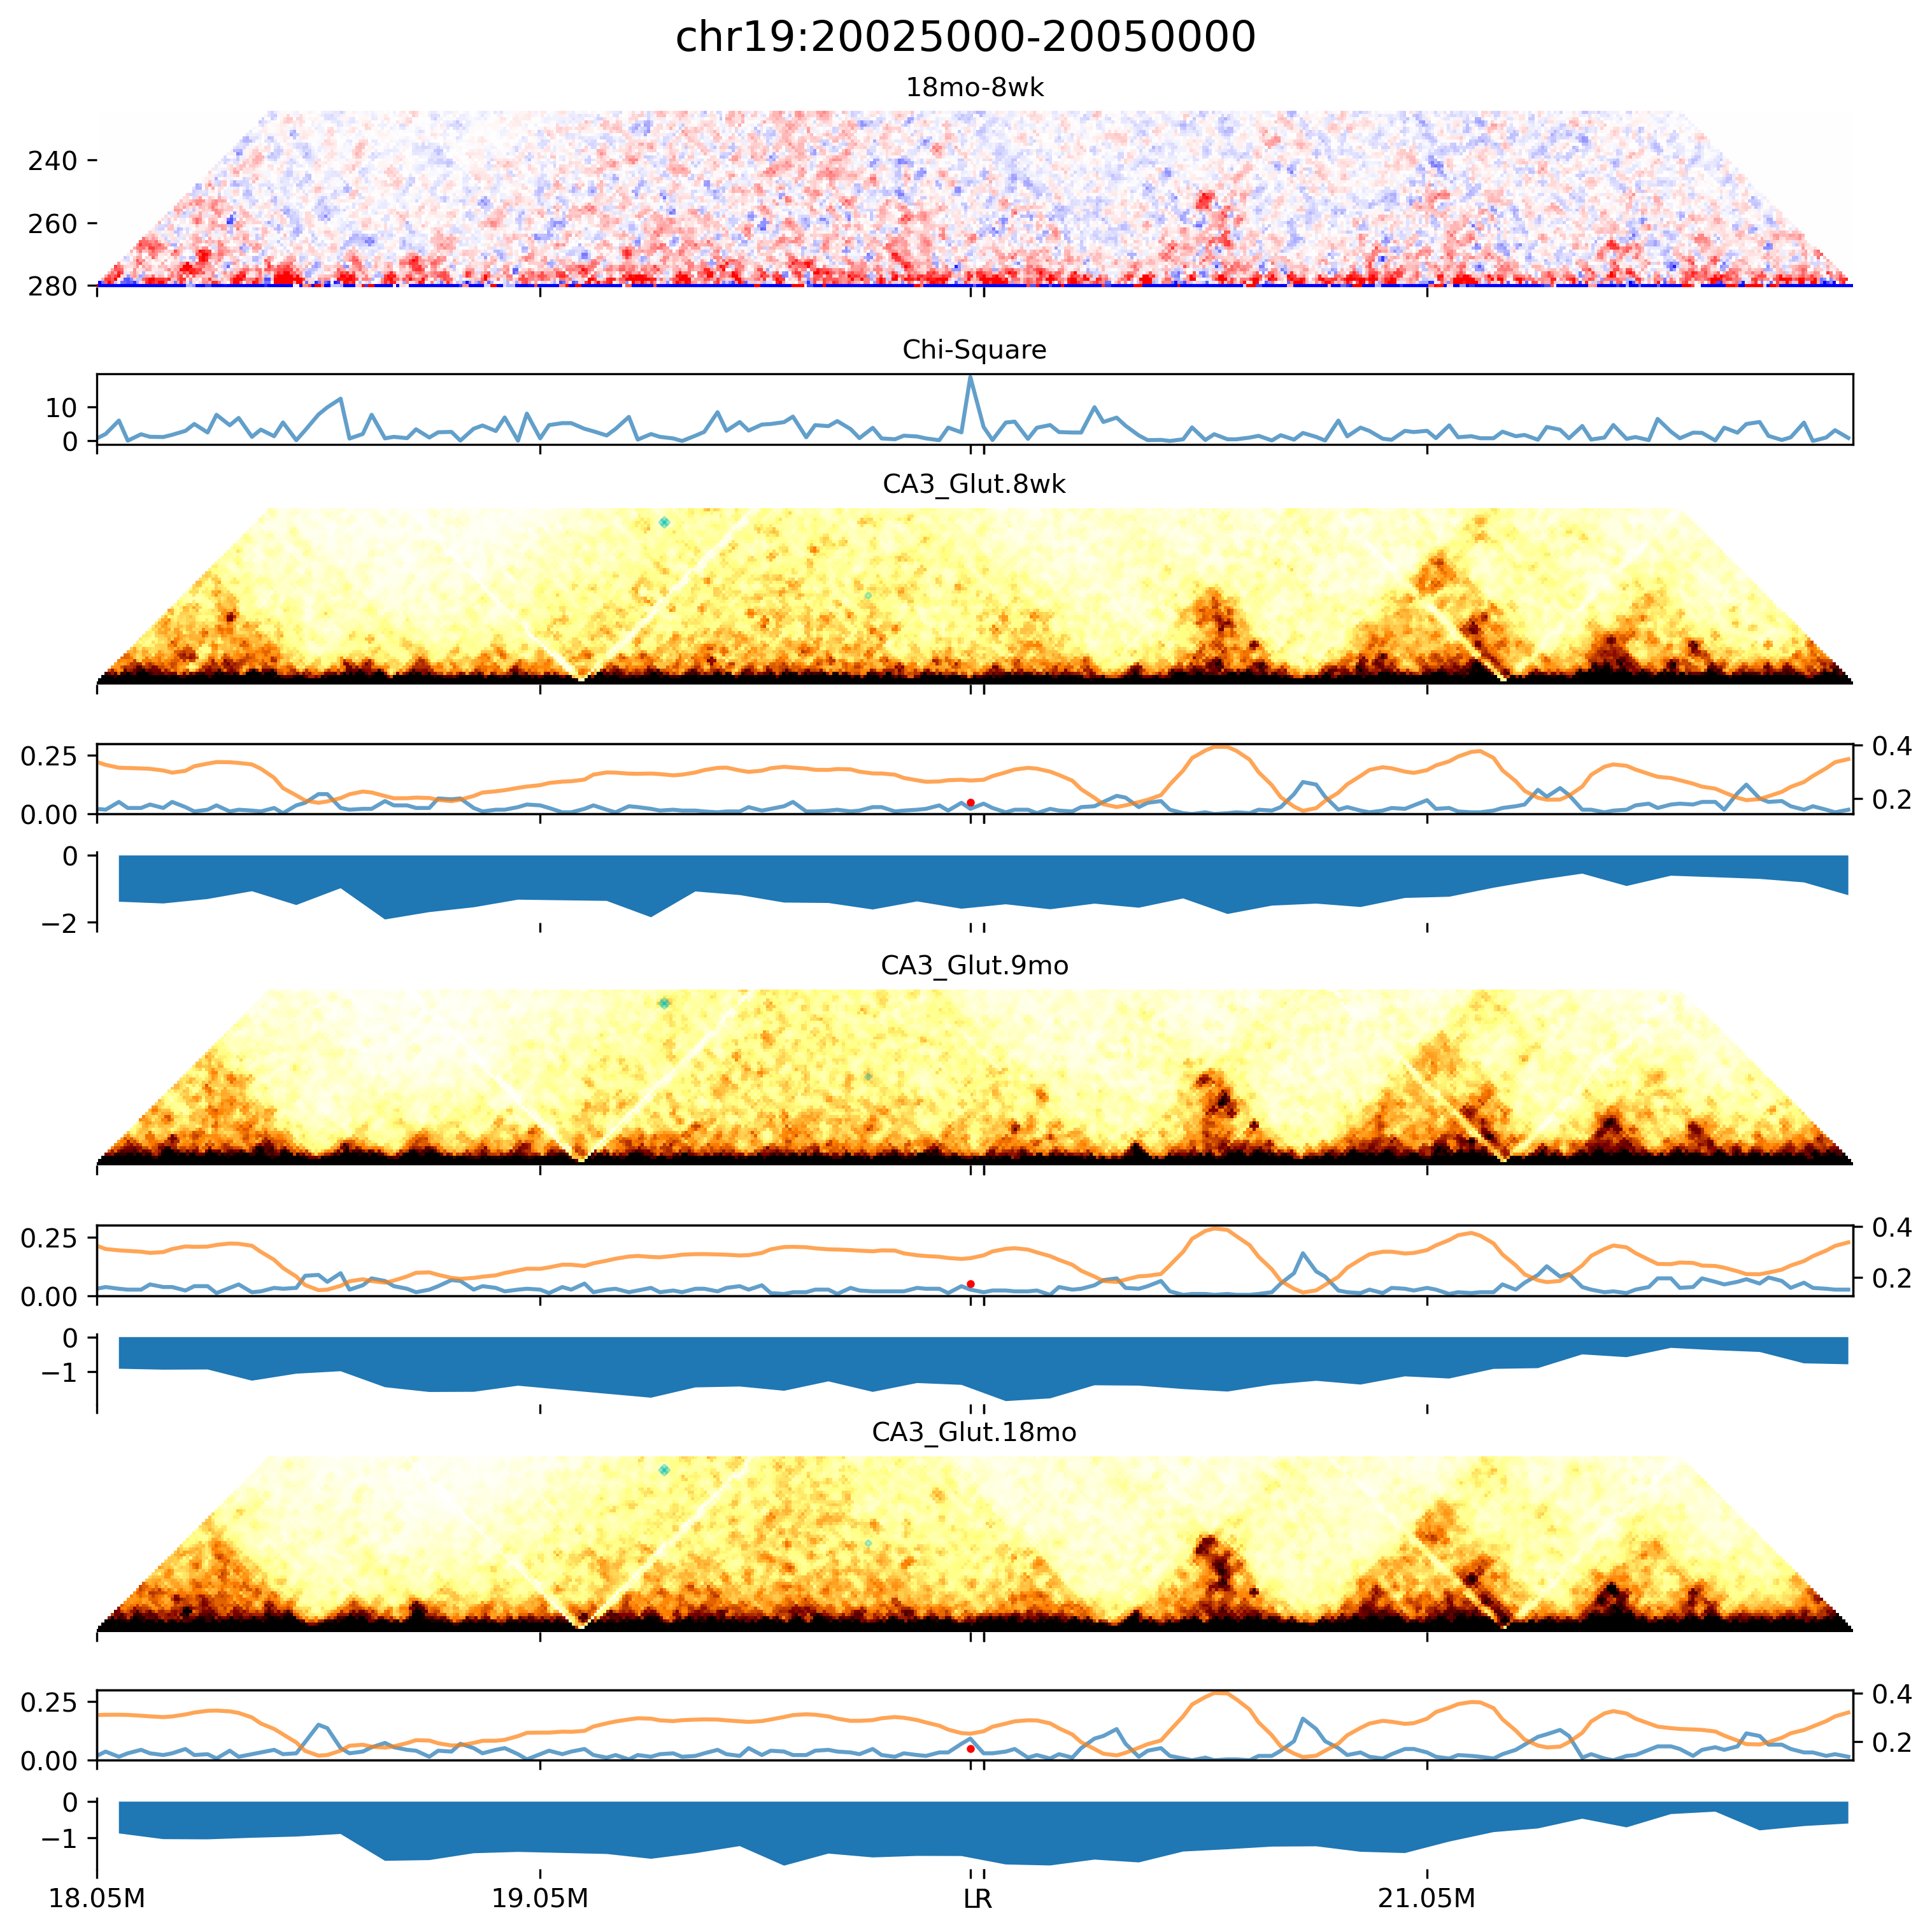

In [97]:
required_repetitions = len(leg)
height_ratios = [3.5]+[1] + np.tile([3.5, 1,1], required_repetitions).tolist()
nrows = len(leg) * 3 + 2

fig, axes = plt.subplots(nrows, 1, figsize=(10,10), 
                         gridspec_kw={'height_ratios': height_ratios}, dpi=300, sharex='all', constrained_layout = True)
legname = leg
tmpd = binall.loc[selb, 'start'] // resl - loopl
tmpl = loopall.loc[sell, [1,4]].values // resl - loopl
tmpc = bincomp.loc[diff_selc, 'start'] // resl - loopl

ax = axes[0]
change = dstall[2] -dstall[0]
vmax  = 0.005
h = len(change)
ax.set_title('18mo-8wk', fontsize=10)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
img = ax.imshow(change, cmap='bwr',vmin=-vmax, vmax=vmax) 
ax.set_ylim([0.5*h, 0.4*h])

ax = axes[1] 
sel = (binall['chrom']==chrom) & (binall['start']>=ll) & (binall['start']<rr)
xpos = (binall.loc[sel, 'start'] // resl - loopl) * np.sqrt(2)
ax.plot(xpos, binall.loc[sel, 'chi2_sc'].values, 
        c='C0', alpha=0.7)

ax.set_title('Chi-Square', fontsize=10)
ax.set_xlim([0, (loopr-loopl-1)*np.sqrt(2)])

for i in range(len(leg)):
    
    vmax  = 0.01
    ax = axes[i*3+2]
    ax.set_title(legname[i], fontsize=10)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    img = ax.imshow(dstall[i], cmap='afmhot_r',vmin=0, vmax=vmax) #, 
    h = len(dstall[i])
    ax.set_ylim([0.5*h, 0.4*h])
    ax.set_xlim([0, h])
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.scatter((tmpl[:, 0]+tmpl[:, 1])/np.sqrt(2), 0.5*h-(tmpl[:, 1]-tmpl[:, 0])/np.sqrt(2), 
           alpha=0.4, s=2, marker='D', edgecolors='c', color='none')
    
    ax = axes[i*3+3]
    ax.plot(xpos, bound_prob_ct.loc[leg[i], sel].values, c='C0', alpha=0.7)
    ax.scatter(tmpd * np.sqrt(2), np.zeros(len(tmpd))+0.05, color='r', s=4)
    ax.set_ylim([0, 0.3])
    ax2 = ax.twinx()
    x = ( binall.loc[sel, 'start'] // resl - loopl ) * np.sqrt(2)
    ## plot insulation score, use 10k coordinate
    ax2.plot(x, 
             ins.loc[leg[i], sel].values, 
             c='C1', alpha=0.7)
   

    ax = axes[i*3+4]
    sns.despine(bottom=True, ax=ax)
    ## plot compartment, use 10k coordinate
    selc = (bincomp['chr']==chrom) & (bincomp['start']>=ll) & (bincomp['start']<rr)
    x = ( bincomp.loc[selc, 'start'] // resl - loopl ) * np.sqrt(2)
    y = comp.loc[selc, leg[i]].values
    ax.fill_between(x, y, 0, where=y >= 0, facecolor='C3', interpolate=True)
    ax.fill_between(x, y, 0, where=y <= 0, facecolor='C0', interpolate=True)
    ax.scatter(tmpc  * np.sqrt(2), np.zeros(len(tmpc)), color='r', s=4)
    
ax.set_xlim([0, (loopr-loopl-1)*np.sqrt(2)])
ax.set_xticks(np.sqrt(2)*np.array(np.arange(0, loopr-loopl+1, 100).tolist() + [diff_domain_l//resl-loopl, diff_domain_r//resl-loopl]))
ax.set_xticklabels([])
ax.set_xticklabels([f'{(xx+loopl)/100}M' for xx in np.arange(0, loopr-loopl+1, 100)]+['L','R'])
fig.suptitle(f"{chrom}:{diff_domain_l}-{diff_domain_r}", fontsize=16)
#fig.savefig(f'figure/LTR.pdf', bbox_inches = 'tight')